In [7]:
import os
import cv2
import glob
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify

## Selecting the train and test images for which we have masks

In [2]:
# Define the paths to the train, test, masks, train_sample, and mask_sample folders
train_folder = 'original_data/train'
test_folder = 'original_data/test'
masks_folder = 'original_data/Masks'

train_sample_folder = 'original_data/train_sample'
train_sample_masks_folder = 'original_data/train_sample_masks'

test_sample_folder = 'original_data/test_sample'
test_sample_masks_folder = 'original_data/test_sample_masks'


# Function to check if all mask files exist for an image
def has_all_masks(image_name):
    root_mask = os.path.join(masks_folder, f"{image_name}_root_mask.tif")
    occluded_root_mask = os.path.join(masks_folder, f"{image_name}_occluded_root_mask.tif")
    seed_mask = os.path.join(masks_folder, f"{image_name}_seed_mask.tif")
    shoot_mask = os.path.join(masks_folder, f"{image_name}_shoot_mask.tif")

    return (
        os.path.exists(root_mask) and
        os.path.exists(occluded_root_mask) and
        os.path.exists(seed_mask) and
        os.path.exists(shoot_mask)
    )

In [3]:
# Loop through the train folder
for image_name in os.listdir(train_folder):
    image_path = os.path.join(train_folder, image_name)

    # Check if all mask files exist for the current image
    if has_all_masks(os.path.splitext(image_name)[0]):
        # Copy the image to train_sample folder
        shutil.copy(image_path, os.path.join(train_sample_folder, image_name))

        # Copy the masks to mask_sample folder
        for mask_type in ['root', 'occluded_root', 'seed', 'shoot']:
            mask_file = f"{image_name.split('.')[0]}_{mask_type}_mask.tif"
            mask_path = os.path.join(masks_folder, mask_file)
            shutil.copy(mask_path, os.path.join(train_sample_masks_folder, mask_file))
            
print("Data preparation complete.")

Data preparation complete.


In [4]:
# Loop through the test folder and perform the same steps
for image_name in os.listdir(test_folder):
    image_path = os.path.join(test_folder, image_name)

    # Check if all mask files exist for the current image
    if has_all_masks(os.path.splitext(image_name)[0]):
        # Copy the image to test_sample folder
        shutil.copy(image_path, os.path.join(test_sample_folder, image_name))

        # Copy the masks to mask_sample folder
        for mask_type in ['root', 'occluded_root', 'seed', 'shoot']:
            mask_file = f"{image_name.split('.')[0]}_{mask_type}_mask.tif"
            mask_path = os.path.join(masks_folder, mask_file)
            shutil.copy(mask_path, os.path.join(test_sample_masks_folder, mask_file))

print("Data preparation complete.")

Data preparation complete.


## Cropping the images and masks

Image shape: (3006, 4202, 3)
Mask shape: (3006, 4202)
Image data type: uint8
Mask data type: uint8
Image pixel values: 0-255
Mask pixel values: 0-1


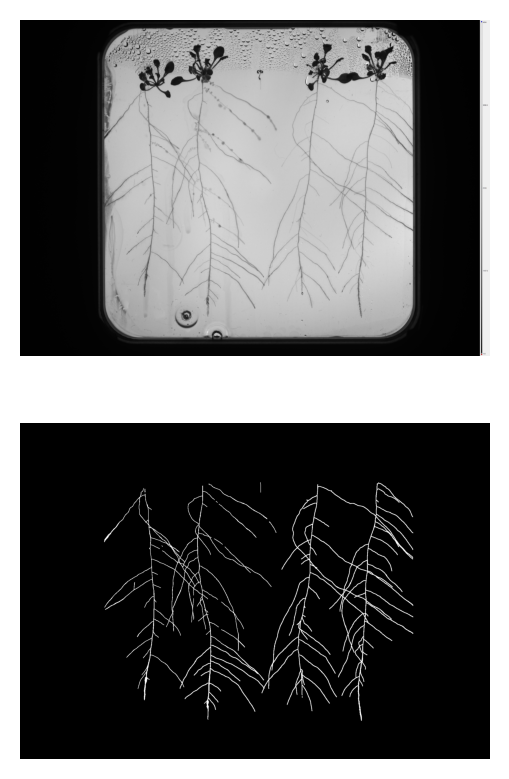

In [5]:
image_path = 'original_data/train_sample/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected.png'
mask_path = 'original_data/train_sample_masks/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected_root_mask.tif'

image = cv2.imread(image_path)
mask = cv2.imread(mask_path, 0)


fig, ax = plt.subplots(2, dpi=200)
ax[0].imshow(image)
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].axis('off')

# And some dataset info
print(f'Image shape: {image.shape}')
print(f'Mask shape: {mask.shape}')
print(f'Image data type: {image.dtype}')
print(f'Mask data type: {mask.dtype}')
print(f'Image pixel values: {np.min(image)}-{np.max(image)}')
print(f'Mask pixel values: {np.min(mask)}-{np.max(mask)}')

In [6]:
import os
path = 'original_data/train_sample_masks'
count = 0
for file in os.listdir(path):
    if file.endswith('_root_mask.tif'):
        if "occ" not in file:
            count += 1
print(f'The number of files in {path} that end with that mask is {count}.')


The number of files in original_data/train_sample_masks that end with that mask is 79.


In [7]:
path = 'original_data/train_sample_masks'
count = 0
for file in os.listdir(path):
    if file.endswith('_shoot_mask.tif'):
        if "occ" not in file:
            count += 1
print(f'The number of files in {path} that end with that mask is {count}.')


The number of files in original_data/train_sample_masks that end with that mask is 79.


In [8]:
def process_images_in_folder(images_folder, masks_folder, processed_images_folder, processed_masks_folder, reference_image_path):
    """
    Processes all images in the specified folder by applying the cropping reference obtained from the reference image,
    saving the processed images to a new folder, and doing the same for the corresponding masks.

    Args:
        images_folder (str): The path to the folder containing images.
        masks_folder (str): The path to the folder containing masks.
        processed_images_folder (str): The path to the folder where processed images should be saved.
        processed_masks_folder (str): The path to the folder where processed masks should be saved.
        reference_image_path (str): The path to the reference image for consistent cropping.

    Returns:
        None
    """

    # Read the reference image in color mode
    reference_im = cv2.imread(reference_image_path, cv2.IMREAD_COLOR)

    # Convert the reference image to grayscale for thresholding
    reference_im_gray = cv2.cvtColor(reference_im, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's method to the grayscale reference image to make it binary
    _, reference_im_binary = cv2.threshold(reference_im_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find the contours in the binary reference image
    contours, hierarchy = cv2.findContours(reference_im_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour, which should be the petri dish in the reference image
    largest_contour = max(contours, key=cv2.contourArea)

    # Find the bounding rectangle of the largest contour in the reference image
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    print(f'x is: {x}')
    print(f'y is: {y}')
    print(f'w is: {w}')
    print(f'h is: {h}')

    # Iterate over the images and masks in the specified folders
    for image_filename in os.listdir(images_folder):
        # Construct the paths for the current image and mask
        image_path = os.path.join(images_folder, image_filename)
        
        mask_label = ['_root_mask.tif', '_shoot_mask.tif','_occluded_root_mask.tif', '_seed_mask.tif']

        for i in mask_label:

            mask_path = os.path.join(masks_folder, image_filename.replace('.png', i))

            # Read the image and mask in color mode
            im = cv2.imread(image_path, cv2.IMREAD_COLOR)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Crop the original color image to the bounding square based on the reference image
            img = im[y:y + h, x:x + w]

            # Crop the mask to the same region
            mask_cropped = mask[y:y + h, x:x + w]

            # Save the processed image to the specified folder
            processed_image_path = os.path.join(processed_images_folder, image_filename)
            cv2.imwrite(processed_image_path, img)

            # Save the processed mask to the specified folder
            processed_mask_path = os.path.join(processed_masks_folder, image_filename.replace('.png', i))
            cv2.imwrite(processed_mask_path, mask_cropped)

    print(f"Processing complete for images in {images_folder} and masks in {masks_folder}.")


In [9]:
# Usage for train set:
process_images_in_folder(
    images_folder='original_data/train_sample',
    masks_folder='original_data/train_sample_masks',
    processed_images_folder='cropped_data/train_images_cropped/train',
    processed_masks_folder='cropped_data/train_masks_cropped/train',
    reference_image_path= image_path
)

x is: 753
y is: 67
w is: 2763
h is: 2774
Processing complete for images in original_data/train_sample and masks in original_data/train_sample_masks.


In [10]:
# Usage for test set:
process_images_in_folder(
    images_folder='original_data/test_sample',
    masks_folder='original_data/test_sample_masks',
    processed_images_folder='cropped_data/test_images_cropped/test',
    processed_masks_folder='cropped_data/test_masks_cropped/test',
    reference_image_path= image_path
)

x is: 753
y is: 67
w is: 2763
h is: 2774
Processing complete for images in original_data/test_sample and masks in original_data/test_sample_masks.


Image shape: (2774, 2763, 3)
Mask shape: (2774, 2763)
Image data type: uint8
Mask data type: uint8
Image pixel values: 2-255
Mask pixel values: 0-1


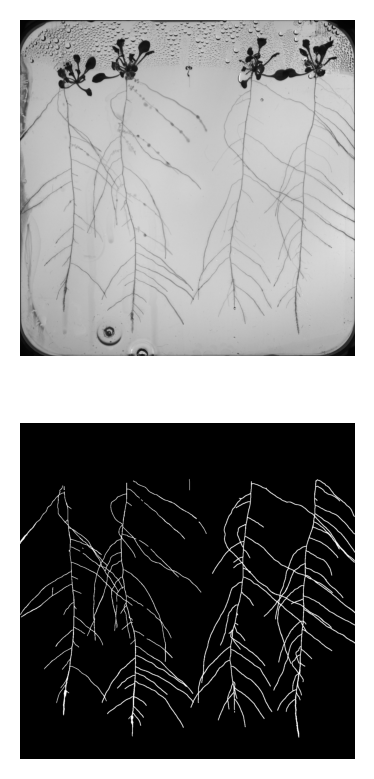

In [11]:
image_path_train_c = 'cropped_data/train_images_cropped/train/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected.png'
mask_path_train_c = 'cropped_data/train_masks_cropped//train/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected_root_mask.tif'

image = cv2.imread(image_path_train_c)
mask = cv2.imread(mask_path_train_c, 0)


fig, ax = plt.subplots(2, dpi=200)
ax[0].imshow(image)
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].axis('off')

# And some info
print(f'Image shape: {image.shape}')
print(f'Mask shape: {mask.shape}')
print(f'Image data type: {image.dtype}')
print(f'Mask data type: {mask.dtype}')
print(f'Image pixel values: {np.min(image)}-{np.max(image)}')
print(f'Mask pixel values: {np.min(mask)}-{np.max(mask)}')

## Creating the background mask label

In [12]:
def create_and_save_background_masks(dataset_type):
    """
    Creates and saves background masks for a given dataset type.

    Parameters:
    - dataset_type (str): The type of the dataset to process (e.g., 'train', 'test').

    Returns:
    None. The function saves the background masks as .tif files in the same folder as the original images.
    """
    images_folder = f'cropped_data/{dataset_type}_images_cropped/{dataset_type}'
    masks_folder = f'cropped_data/{dataset_type}_masks_cropped/{dataset_type}'

    for image_filename in os.listdir(images_folder):
        # Construct the path for the current image
        image_path = os.path.join(images_folder, image_filename)

        # Sum up the values of the four mask labels for the current image
        mask_label = ['_root_mask.tif', '_shoot_mask.tif', '_occluded_root_mask.tif', '_seed_mask.tif']
        sum_masks = None

        for i in mask_label:
            mask_path = os.path.join(masks_folder, image_filename.replace('.png', i))

            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if sum_masks is None:
                    sum_masks = np.zeros_like(mask, dtype=np.uint8)
                sum_masks += mask

        # Invert the sum to create the background mask
        background_mask = cv2.bitwise_not(sum_masks)

        # Threshold to set values smaller than 255 to 0
        background_mask[background_mask < 255] = 0

        # Normalize pixel values to the range [0, 1]
        background_mask = background_mask / 255.0

        # Save the background mask with the new filename
        background_mask_filename = image_filename.replace('.png', '_background_mask.tif')
        background_mask_path = os.path.join(masks_folder, background_mask_filename)
        cv2.imwrite(background_mask_path, (background_mask).astype(np.uint8))

    print(f"Processing complete for {dataset_type} set.")


In [13]:
# Call the function with the appropriate arguments
create_and_save_background_masks('train')

Processing complete for train set.


In [14]:
# Call the function with the appropriate arguments
create_and_save_background_masks('test')

Processing complete for test set.


Image shape: (2774, 2763, 3)
Mask shape: (2774, 2763)
Image data type: uint8
Mask data type: uint8
Image pixel values: 2-255
Mask pixel values: 0-1


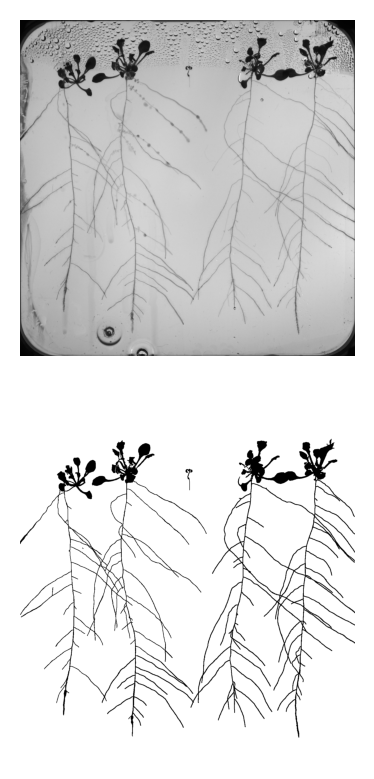

In [15]:
# Testing how the background class looks:

image_path_train_c = 'cropped_data/train_images_cropped/train/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected.png'
mask_path_train_c = 'cropped_data/train_masks_cropped//train/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected_background_mask.tif'

image = cv2.imread(image_path_train_c)
mask = cv2.imread(mask_path_train_c, 0)


fig, ax = plt.subplots(2, dpi=200)
ax[0].imshow(image)
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].axis('off')

# And some info
print(f'Image shape: {image.shape}')
print(f'Mask shape: {mask.shape}')
print(f'Image data type: {image.dtype}')
print(f'Mask data type: {mask.dtype}')
print(f'Image pixel values: {np.min(image)}-{np.max(image)}')
print(f'Mask pixel values: {np.min(mask)}-{np.max(mask)}')

## Creating validation dataset

In [16]:
import os
import random
import shutil

def move_random_images(src_images_folder, src_masks_folder, dest_images_folder, dest_masks_folder, num_images_to_move=15):
    # Get the list of image files
    image_files = os.listdir(src_images_folder)
    
    # Randomly select 15 images
    selected_images = random.sample(image_files, num_images_to_move)

    # Create destination folders if they don't exist
    os.makedirs(dest_images_folder, exist_ok=True)
    os.makedirs(dest_masks_folder, exist_ok=True)

    # Move selected images and their respective masks
    for image in selected_images:
        # Move image
        src_image_path = os.path.join(src_images_folder, image)
        dest_image_path = os.path.join(dest_images_folder, image)
        shutil.move(src_image_path, dest_image_path)

        # Move masks
        mask_suffixes = ['_root_mask.tif', '_shoot_mask.tif', '_occluded_root_mask.tif', '_seed_mask.tif', '_background_mask.tif']
        for suffix in mask_suffixes:
            mask_file = image.replace('.png', suffix)
            src_mask_path = os.path.join(src_masks_folder, mask_file)
            dest_mask_path = os.path.join(dest_masks_folder, mask_file)
            shutil.move(src_mask_path, dest_mask_path)


In [17]:
# Specify the source and destination folders
src_images_folder = "cropped_data/train_images_cropped/train"
src_masks_folder = "cropped_data/train_masks_cropped/train"
dest_images_folder = "cropped_data/val_images_cropped/val"
dest_masks_folder = "cropped_data/val_masks_cropped/val"

# Call the function to move random images
move_random_images(src_images_folder, src_masks_folder, dest_images_folder, dest_masks_folder)

## testing patche size on an image and a mask

Image shape: (2774, 2763, 3)
Mask shape: (2774, 2763)
Image data type: uint8
Mask data type: uint8
Image pixel values: 3-255
Mask pixel values: 0-1


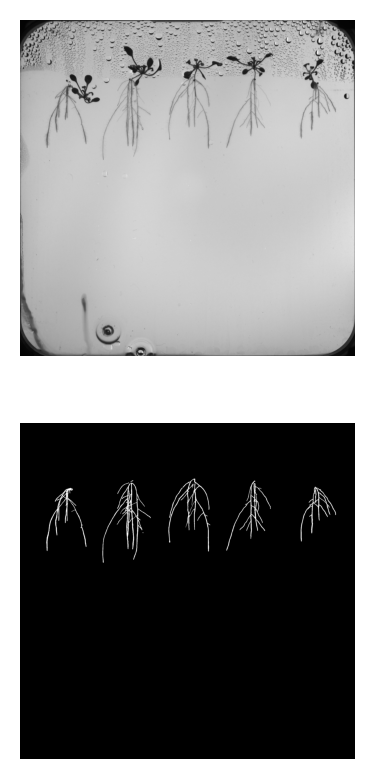

In [18]:
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

image_path_train_c = 'cropped_data/train_images_cropped/train/025_43-17-ROOT1-2023-08-08_pvdCherry_OD01_Col0_04-Fish Eye Corrected.png'
mask_path_train_c = 'cropped_data/train_masks_cropped/train/025_43-17-ROOT1-2023-08-08_pvdCherry_OD01_Col0_04-Fish Eye Corrected_root_mask.tif'

image = cv2.imread(image_path_train_c)
mask = cv2.imread(mask_path_train_c, 0)


fig, ax = plt.subplots(2, dpi=200)
ax[0].imshow(image)
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].axis('off')

# And some dataset info
print(f'Image shape: {image.shape}')
print(f'Mask shape: {mask.shape}')
print(f'Image data type: {image.dtype}')
print(f'Mask data type: {mask.dtype}')
print(f'Image pixel values: {np.min(image)}-{np.max(image)}')
print(f'Mask pixel values: {np.min(mask)}-{np.max(mask)}')

In [19]:
def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

In [20]:
patch_size = 256

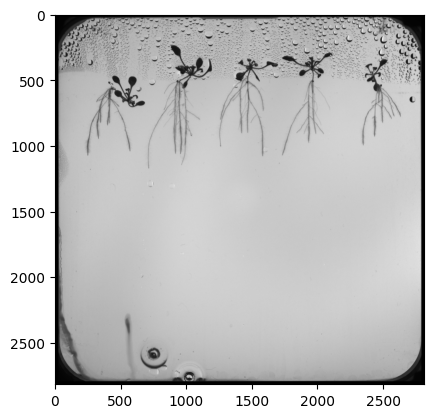

In [21]:
image = padder(image, 256)
plt.imshow(image)

In [22]:
patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)

In [23]:
i = patches.shape[0]
j = patches.shape[1]

In [24]:
patches = patches.reshape(-1, patch_size, patch_size, 3)
patches.shape

(121, 256, 256, 3)

In [27]:
patch_size = 256
mask = cv2.imread(mask_path_train_c)
mask = mask * 255
mask = padder(mask, patch_size)
patches = patchify(mask, (patch_size, patch_size, 1), step=patch_size)
patches.shape

(11, 11, 1, 256, 256, 1)

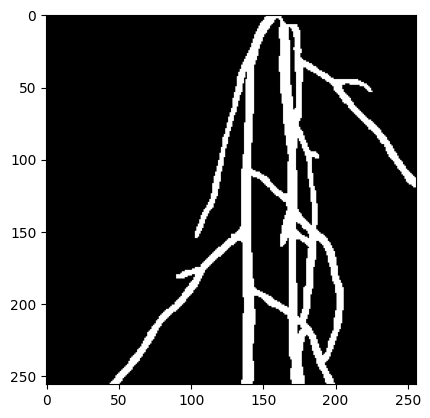

In [28]:
plt.imshow(patches[2, 7, 0], cmap='gray')

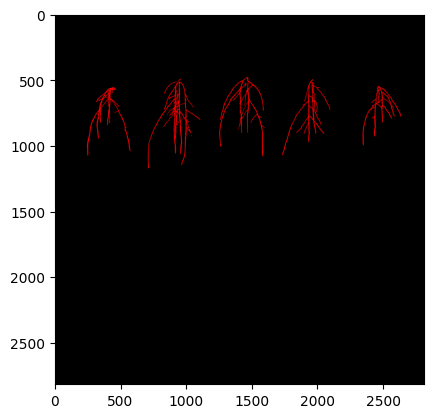

In [29]:
plt.imshow(unpatchify(patches, mask.shape))

## Creating data patches

### For images

In [30]:
def create_and_save_patches(dataset_type, patch_size, scaling_factor):
    """
    Splits images and their corresponding masks into smaller patches and saves them.

    Parameters:
    - dataset_type (str): The type of the dataset to process (e.g., 'train', 'test').
    - patch_size (int): The size of the patches to be created.
    - scaling_factor (float): The factor by which the images and masks should be scaled.
    - type_of_mask (str): The type of mask to process ('root', 'background', etc.) and assign to the y coordinates

    Returns:
    None. The function saves the patches as .png files in directories based on their original paths, but replacing 'data' with 'data_patched'.
    """
    image_folder = f'cropped_data/{dataset_type}_images_cropped/{dataset_type}'
    images_patch_dir = f'data_patched/{dataset_type}_images/{dataset_type}'

    for image_filename in os.listdir(image_folder):
        # Construct the path for the current image and mask files
        image_path = os.path.join(image_folder, image_filename)

        # Check if the corresponding root mask file exists
        if os.path.exists(mask_path):
            # Process image
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = padder(image, patch_size)
            image = np.array(image)  # Convert to numpy array

            # Apply scaling factor if needed
            if scaling_factor != 1:
                image = cv2.resize(image, (0, 0), fx=scaling_factor, fy=scaling_factor)

            # Create patches for the image
            image_patches = patchify(image, (patch_size, patch_size), step=patch_size)
            image_patches = image_patches.reshape(-1, patch_size, patch_size, 1)

            # Save patches for the image
            for i, img_patch in enumerate(image_patches):
                img_patch_path = os.path.join(images_patch_dir, f'{image_filename[:-4]}_{i}.png')
                cv2.imwrite(img_patch_path, img_patch)

    print(f"Processing complete for {dataset_type} set images.")


In [31]:
create_and_save_patches('train', patch_size=256, scaling_factor=1.0)

Processing complete for train set images.


In [32]:
create_and_save_patches('test', patch_size=256, scaling_factor=1.0)

Processing complete for test set images.


In [33]:
create_and_save_patches('val', patch_size=256, scaling_factor=1.0)

Processing complete for val set images.


### For root

In [34]:
def create_and_save_patches_root(dataset_type, patch_size, scaling_factor):
    """
    Splits images and their corresponding masks into smaller patches and saves them.

    Parameters:
    - dataset_type (str): The type of the dataset to process (e.g., 'train', 'test').
    - patch_size (int): The size of the patches to be created.
    - scaling_factor (float): The factor by which the images and masks should be scaled.
    - type_of_mask (str): The type of mask to process ('root', 'background', etc.) and assign to the y coordinates

    Returns:
    None. The function saves the patches as .png files in directories based on their original paths, but replacing 'data' with 'data_patched'.
    """
    image_folder = f'cropped_data/{dataset_type}_images_cropped/{dataset_type}'
    mask_folder = f'cropped_data/{dataset_type}_masks_cropped/{dataset_type}'
    masks_patch_dir = f'data_patched/{dataset_type}_masks_root/{dataset_type}'

    for image_filename in os.listdir(image_folder):
        # Construct the path for the current image and mask files
        image_path = os.path.join(image_folder, image_filename)
        mask_filename = image_filename.replace('.png', '_root_mask.tif')
        mask_path = os.path.join(mask_folder, mask_filename)

        # Check if the corresponding root mask file exists
        if os.path.exists(mask_path):

            # Process root mask
            root_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            root_mask = padder(root_mask, patch_size)
            root_mask = np.array(root_mask)

            # Create patches for the root mask
            mask_patches = patchify(root_mask, (patch_size, patch_size), step=patch_size)
            mask_patches = mask_patches.reshape(-1, patch_size, patch_size, 1)

            # Save patches for the root mask
            for i, mask_patch in enumerate(mask_patches):
                mask_patch_path = os.path.join(masks_patch_dir, f'{image_filename[:-4]}_{i}.png')
                cv2.imwrite(mask_patch_path, mask_patch)

    print(f"Processing complete for {dataset_type} set images.")


In [35]:
create_and_save_patches_root('train', patch_size=256, scaling_factor=1.0)

Processing complete for train set images.


In [36]:
create_and_save_patches_root('test', patch_size=256, scaling_factor=1.0)

Processing complete for test set images.


In [37]:
create_and_save_patches_root('val', patch_size=256, scaling_factor=1.0)

Processing complete for val set images.


### For seed

In [38]:
def create_and_save_patches_seed(dataset_type, patch_size, scaling_factor):
    """
    Splits images and their corresponding masks into smaller patches and saves them.

    Parameters:
    - dataset_type (str): The type of the dataset to process (e.g., 'train', 'test').
    - patch_size (int): The size of the patches to be created.
    - scaling_factor (float): The factor by which the images and masks should be scaled.
    - type_of_mask (str): The type of mask to process ('root', 'background', etc.) and assign to the y coordinates

    Returns:
    None. The function saves the patches as .png files in directories based on their original paths, but replacing 'data' with 'data_patched'.
    """
    image_folder = f'cropped_data/{dataset_type}_images_cropped/{dataset_type}'
    mask_folder = f'cropped_data/{dataset_type}_masks_cropped/{dataset_type}'
    masks_patch_dir = f'data_patched/{dataset_type}_masks_seed/{dataset_type}'

    for image_filename in os.listdir(image_folder):
        # Construct the path for the current image and mask files
        image_path = os.path.join(image_folder, image_filename)
        mask_filename = image_filename.replace('.png', '_seed_mask.tif')
        mask_path = os.path.join(mask_folder, mask_filename)

        # Check if the corresponding root mask file exists
        if os.path.exists(mask_path):

            # Process root mask
            root_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            root_mask = padder(root_mask, patch_size)
            root_mask = np.array(root_mask)

            # Create patches for the root mask
            mask_patches = patchify(root_mask, (patch_size, patch_size), step=patch_size)
            mask_patches = mask_patches.reshape(-1, patch_size, patch_size, 1)

            # Save patches for the root mask
            for i, mask_patch in enumerate(mask_patches):
                mask_patch_path = os.path.join(masks_patch_dir, f'{image_filename[:-4]}_{i}.png')
                cv2.imwrite(mask_patch_path, mask_patch)

    print(f"Processing complete for {dataset_type} set images.")


In [39]:
create_and_save_patches_seed('train', patch_size=256, scaling_factor=1.0)

Processing complete for train set images.


In [40]:
create_and_save_patches_seed('test', patch_size=256, scaling_factor=1.0)

Processing complete for test set images.


In [41]:
create_and_save_patches_seed('val', patch_size=256, scaling_factor=1.0)

Processing complete for val set images.


### For shoot

In [42]:
def create_and_save_patches_shoot(dataset_type, patch_size, scaling_factor):
    """
    Splits images and their corresponding masks into smaller patches and saves them.

    Parameters:
    - dataset_type (str): The type of the dataset to process (e.g., 'train', 'test').
    - patch_size (int): The size of the patches to be created.
    - scaling_factor (float): The factor by which the images and masks should be scaled.
    - type_of_mask (str): The type of mask to process ('root', 'background', etc.) and assign to the y coordinates

    Returns:
    None. The function saves the patches as .png files in directories based on their original paths, but replacing 'data' with 'data_patched'.
    """
    image_folder = f'cropped_data/{dataset_type}_images_cropped/{dataset_type}'
    mask_folder = f'cropped_data/{dataset_type}_masks_cropped/{dataset_type}'
    masks_patch_dir = f'data_patched/{dataset_type}_masks_shoot/{dataset_type}'

    for image_filename in os.listdir(image_folder):
        # Construct the path for the current image and mask files
        image_path = os.path.join(image_folder, image_filename)
        mask_filename = image_filename.replace('.png', '_shoot_mask.tif')
        mask_path = os.path.join(mask_folder, mask_filename)

        # Check if the corresponding root mask file exists
        if os.path.exists(mask_path):

            # Process root mask
            root_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            root_mask = padder(root_mask, patch_size)
            root_mask = np.array(root_mask)

            # Create patches for the root mask
            mask_patches = patchify(root_mask, (patch_size, patch_size), step=patch_size)
            mask_patches = mask_patches.reshape(-1, patch_size, patch_size, 1)

            # Save patches for the root mask
            for i, mask_patch in enumerate(mask_patches):
                mask_patch_path = os.path.join(masks_patch_dir, f'{image_filename[:-4]}_{i}.png')
                cv2.imwrite(mask_patch_path, mask_patch)

    print(f"Processing complete for {dataset_type} set images.")


In [43]:
create_and_save_patches_shoot('train', patch_size=256, scaling_factor=1.0)

Processing complete for train set images.


In [44]:
create_and_save_patches_shoot('test', patch_size=256, scaling_factor=1.0)

Processing complete for test set images.


In [45]:
create_and_save_patches_shoot('val', patch_size=256, scaling_factor=1.0)

Processing complete for val set images.


### For background

In [46]:
def create_and_save_patches_background(dataset_type, patch_size, scaling_factor):
    """
    Splits images and their corresponding masks into smaller patches and saves them.

    Parameters:
    - dataset_type (str): The type of the dataset to process (e.g., 'train', 'test').
    - patch_size (int): The size of the patches to be created.
    - scaling_factor (float): The factor by which the images and masks should be scaled.
    - type_of_mask (str): The type of mask to process ('root', 'background', etc.) and assign to the y coordinates

    Returns:
    None. The function saves the patches as .png files in directories based on their original paths, but replacing 'data' with 'data_patched'.
    """
    image_folder = f'cropped_data/{dataset_type}_images_cropped/{dataset_type}'
    mask_folder = f'cropped_data/{dataset_type}_masks_cropped/{dataset_type}'
    masks_patch_dir = f'data_patched/{dataset_type}_masks_background/{dataset_type}'

    for image_filename in os.listdir(image_folder):
        # Construct the path for the current image and mask files
        image_path = os.path.join(image_folder, image_filename)
        mask_filename = image_filename.replace('.png', '_background_mask.tif')
        mask_path = os.path.join(mask_folder, mask_filename)

        # Check if the corresponding root mask file exists
        if os.path.exists(mask_path):

            # Process root mask
            root_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            root_mask = padder(root_mask, patch_size)
            root_mask = np.array(root_mask)

            # Create patches for the root mask
            mask_patches = patchify(root_mask, (patch_size, patch_size), step=patch_size)
            mask_patches = mask_patches.reshape(-1, patch_size, patch_size, 1)

            # Save patches for the root mask
            for i, mask_patch in enumerate(mask_patches):
                mask_patch_path = os.path.join(masks_patch_dir, f'{image_filename[:-4]}_{i}.png')
                cv2.imwrite(mask_patch_path, mask_patch)

    print(f"Processing complete for {dataset_type} set images.")


In [47]:
create_and_save_patches_background('train', patch_size=256, scaling_factor=1.0)

Processing complete for train set images.


In [48]:
create_and_save_patches_background('test', patch_size=256, scaling_factor=1.0)

Processing complete for test set images.


In [49]:
create_and_save_patches_background('val', patch_size=256, scaling_factor=1.0)

Processing complete for val set images.


### For occluded_root

In [50]:
def create_and_save_patches_occ_root(dataset_type, patch_size, scaling_factor):
    """
    Splits images and their corresponding masks into smaller patches and saves them.

    Parameters:
    - dataset_type (str): The type of the dataset to process (e.g., 'train', 'test').
    - patch_size (int): The size of the patches to be created.
    - scaling_factor (float): The factor by which the images and masks should be scaled.
    - type_of_mask (str): The type of mask to process ('root', 'background', etc.) and assign to the y coordinates

    Returns:
    None. The function saves the patches as .png files in directories based on their original paths, but replacing 'data' with 'data_patched'.
    """
    image_folder = f'cropped_data/{dataset_type}_images_cropped/{dataset_type}'
    mask_folder = f'cropped_data/{dataset_type}_masks_cropped/{dataset_type}'
    masks_patch_dir = f'data_patched/{dataset_type}_masks_occ_root/{dataset_type}'

    for image_filename in os.listdir(image_folder):
        # Construct the path for the current image and mask files
        image_path = os.path.join(image_folder, image_filename)
        mask_filename = image_filename.replace('.png', '_occluded_root_mask.tif')
        mask_path = os.path.join(mask_folder, mask_filename)

        # Check if the corresponding root mask file exists
        if os.path.exists(mask_path):

            # Process root mask
            root_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            root_mask = padder(root_mask, patch_size)
            root_mask = np.array(root_mask)

            # Create patches for the root mask
            mask_patches = patchify(root_mask, (patch_size, patch_size), step=patch_size)
            mask_patches = mask_patches.reshape(-1, patch_size, patch_size, 1)

            # Save patches for the root mask
            for i, mask_patch in enumerate(mask_patches):
                mask_patch_path = os.path.join(masks_patch_dir, f'{image_filename[:-4]}_{i}.png')
                cv2.imwrite(mask_patch_path, mask_patch)

    print(f"Processing complete for {dataset_type} set images.")


In [51]:
create_and_save_patches_occ_root('train', patch_size=256, scaling_factor=1.0)

Processing complete for train set images.


In [52]:
create_and_save_patches_occ_root('test', patch_size=256, scaling_factor=1.0)

Processing complete for test set images.


In [53]:
create_and_save_patches_occ_root('val', patch_size=256, scaling_factor=1.0)

Processing complete for val set images.


## Creating a singular mask out of a full image to test 

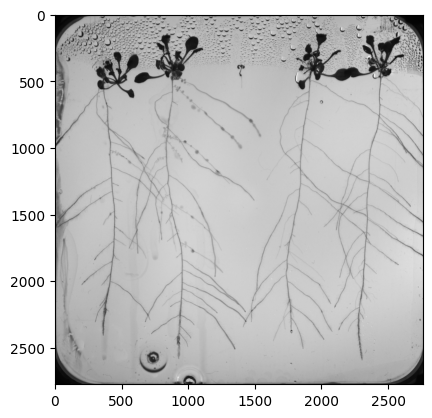

In [9]:
image_path = 'cropped_data/train_images_cropped/train/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected.png'

image = cv2.imread(image_path)

plt.imshow(image)


In [4]:
# Testing how the background class looks:

mask_background = 'cropped_data/train_masks_cropped/train/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected_background_mask.tif'
mask_root = 'cropped_data/train_masks_cropped/train/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected_root_mask.tif'
mask_shoot = 'cropped_data/train_masks_cropped/train/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected_shoot_mask.tif'
mask_seed = 'cropped_data/train_masks_cropped/train/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected_seed_mask.tif'
mask_occ_root = 'cropped_data/train_masks_cropped/train/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected_occluded_root_mask.tif'

mask_background = cv2.imread(mask_background, 0)
mask_root = cv2.imread(mask_root, 0)
mask_shoot = cv2.imread(mask_shoot, 0)
mask_seed = cv2.imread(mask_seed, 0)
mask_occ_root = cv2.imread(mask_occ_root, 0)


# And some info
print(f'Mask shape: {mask_background.shape}')
print(f'Mask data type: {mask_background.dtype}')
print(f'Mask pixel values: {np.min(mask_background)}-{np.max(mask_background)}')

print(f'\nMask shape: {mask_root.shape}')
print(f'Mask data type: {mask_root.dtype}')
print(f'Mask pixel values: {np.min(mask_root)}-{np.max(mask_root)}')

print(f'\nMask shape: {mask_shoot.shape}')
print(f'Mask data type: {mask_shoot.dtype}')
print(f'Mask pixel values: {np.min(mask_shoot)}-{np.max(mask_shoot)}')

print(f'\nMask shape: {mask_seed.shape}')
print(f'Mask data type: {mask_seed.dtype}')
print(f'Mask pixel values: {np.min(mask_seed)}-{np.max(mask_seed)}')

print(f'\nMask shape: {mask_seed.shape}')
print(f'Mask data type: {mask_seed.dtype}')
print(f'Mask pixel values: {np.min(mask_seed)}-{np.max(mask_seed)}')

Mask shape: (2774, 2763)
Mask data type: uint8
Mask pixel values: 0-1

Mask shape: (2774, 2763)
Mask data type: uint8
Mask pixel values: 0-1

Mask shape: (2774, 2763)
Mask data type: uint8
Mask pixel values: 0-1

Mask shape: (2774, 2763)
Mask data type: uint8
Mask pixel values: 0-1

Mask shape: (2774, 2763)
Mask data type: uint8
Mask pixel values: 0-1


all of the masks appear to have pixels between 0 an 1 which is the goal

In [10]:

# Define class mapping
class_mapping = {
    "_masks_background": 0,
    "_masks_root": 1,
    "_masks_shoot": 2,
    "_masks_seed": 3,
    "_masks_occ_root": 4
}

# Paths to the five masks
mask_background_path = 'cropped_data/train_masks_cropped/train/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected_background_mask.tif'
mask_root_path = 'cropped_data/train_masks_cropped/train/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected_root_mask.tif'
mask_shoot_path = 'cropped_data/train_masks_cropped/train/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected_shoot_mask.tif'
mask_seed_path = 'cropped_data/train_masks_cropped/train/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected_seed_mask.tif'
mask_occ_root_path = 'cropped_data/train_masks_cropped/train/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected_occluded_root_mask.tif'

# Read the masks
mask_background = cv2.imread(mask_background_path, 0)
mask_root = cv2.imread(mask_root_path, 0)
mask_shoot = cv2.imread(mask_shoot_path, 0)
mask_seed = cv2.imread(mask_seed_path, 0)
mask_occ_root = cv2.imread(mask_occ_root_path, 0)

# Create an empty mask with the same shape
encoded_mask = np.zeros_like(mask_background, dtype=np.uint8)

# Loop through each mask type
for mask, mapped_value in zip([mask_background, mask_root, mask_shoot, mask_seed, mask_occ_root], class_mapping.values()):
    encoded_mask[mask > 0] = mapped_value

# Display the encoded mask
print(encoded_mask)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


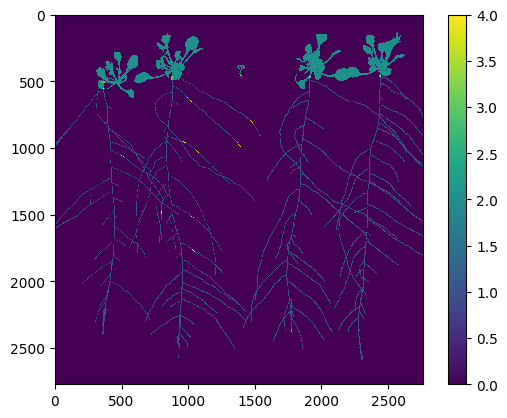

In [11]:
# Display the encoded mask using matplotlib
plt.imshow(encoded_mask, cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()


## Creating the full mask for the whole cropped dataset of 

In [9]:
def encode_masks(data_folder, set_type):
    # Define class mapping
    class_mapping = {
        "_masks_background": 0,
        "_masks_root": 1,
        "_masks_shoot": 2,
        "_masks_seed": 3,
        "_masks_occ_root": 4
    }

    # Input and output folders
    input_images_folder = os.path.join(data_folder, f"{set_type}_images/{set_type}")
    output_images_folder = os.path.join(data_folder, f"{set_type}_masks_encoded/{set_type}")

    # Create output folder if it doesn't exist
    if not os.path.exists(output_images_folder):
        os.makedirs(output_images_folder)

    # List all image files in the input folder
    image_files = os.listdir(input_images_folder)

    # List of mask types
    mask_types = ['_masks_shoot', '_masks_root', '_masks_seed', '_masks_background', '_masks_occ_root']

    for image_file in image_files:
        # Read the original image
        image_path = os.path.join(input_images_folder, image_file)
        original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Create an empty mask with the same shape
        encoded_mask = np.zeros_like(original_image, dtype=np.uint8)

        # Loop through each mask type
        for mask_type_suffix in mask_types:
            mask_folder = os.path.join(data_folder, f"{set_type}{mask_type_suffix}")
            mask_path = os.path.join(mask_folder, set_type, image_file)

            # Read the mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Map pixel values based on the class mapping
            mapped_values = class_mapping[mask_type_suffix]
            encoded_mask[mask > 0] = mapped_values

        # Save the encoded mask
        output_path = os.path.join(output_images_folder, image_file)
        cv2.imwrite(output_path, encoded_mask)

In [10]:
data_folder = "data_patched"

In [11]:
encode_masks(data_folder, "val")

In [12]:
encode_masks(data_folder, "test")

In [13]:
encode_masks(data_folder, "train")